In [1]:
import torch
from torch import nn, cuda
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange

import optuna
from optuna.integration import SkoptSampler # pip install scikit_optimize
from optuna.samplers import RandomSampler
import madgrad # pip install madgrad
import warnings
import matplotlib.pyplot as plt
import random
import os
import shutil
%matplotlib inline

# MISC

### ignore UserWarning

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

### global variables

In [3]:
global device, batch_size, img_size
device = torch.device("cuda" if cuda.is_available() else "cpu")
batch_size = 128
img_size = 24

### reproductibility

In [4]:
global SEED
SEED = 13


def set_seed(random_seed: int = SEED):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

In [5]:
def save_weight(model, path: str, weight_file_name: str):
    os.makedirs(path, exist_ok=True)
    torch.save(model.state_dict(), f"{path}/{weight_file_name}")
    print(f"[+] Saved {path}/{weight_file_name}")

# Data

## parse csv

read csv

In [6]:
df_data = pd.read_csv("age_gender.csv")
print(sorted(df_data["age"].unique()))  # 1 ~ 116
print(sorted(df_data["ethnicity"].unique()))  # 0 ~ 4
print(sorted(df_data["gender"].unique()))  # 0 ~ 4
df_data.head()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 99, 100, 101, 103, 105, 110, 111, 115, 116]
[0, 1, 2, 3, 4]
[0, 1]


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


sort data by age

In [7]:
df_data.sort_values(by="age", inplace=True)
df_data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
740,1,2,1,20161219221154447.jpg.chip.jpg,172 186 196 203 212 210 208 204 197 189 182 17...
741,1,2,1,20161219220631367.jpg.chip.jpg,177 174 171 167 164 159 155 140 171 179 183 18...
742,1,2,1,20161219220611473.jpg.chip.jpg,77 89 98 101 102 105 104 105 91 98 105 110 111...
743,1,2,1,20161219220519457.jpg.chip.jpg,171 172 175 177 178 178 180 183 183 185 185 18...
...,...,...,...,...,...
1371,115,0,1,20170120134725990.jpg.chip.jpg,170 153 145 141 133 140 141 146 144 150 171 17...
1373,116,2,1,20170112220255503.jpg.chip.jpg,207 200 197 181 186 174 184 185 162 164 164 16...
1375,116,0,1,20170112213001988.jpg.chip.jpg,105 86 95 135 159 150 147 147 153 117 148 160 ...
1372,116,0,1,20170120134921760.jpg.chip.jpg,81 91 101 106 113 115 117 121 122 122 122 128 ...


reset index

In [8]:
df_data.reset_index(drop=True, inplace=True)
df_data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,1,20161219221154447.jpg.chip.jpg,172 186 196 203 212 210 208 204 197 189 182 17...
2,1,2,1,20161219220631367.jpg.chip.jpg,177 174 171 167 164 159 155 140 171 179 183 18...
3,1,2,1,20161219220611473.jpg.chip.jpg,77 89 98 101 102 105 104 105 91 98 105 110 111...
4,1,2,1,20161219220519457.jpg.chip.jpg,171 172 175 177 178 178 180 183 183 185 185 18...
...,...,...,...,...,...
23700,115,0,1,20170120134725990.jpg.chip.jpg,170 153 145 141 133 140 141 146 144 150 171 17...
23701,116,2,1,20170112220255503.jpg.chip.jpg,207 200 197 181 186 174 184 185 162 164 164 16...
23702,116,0,1,20170112213001988.jpg.chip.jpg,105 86 95 135 159 150 147 147 153 117 148 160 ...
23703,116,0,1,20170120134921760.jpg.chip.jpg,81 91 101 106 113 115 117 121 122 122 122 128 ...


parse pixels

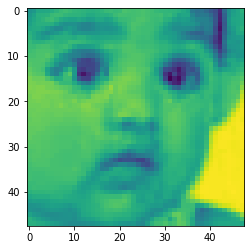

In [9]:
df_data["pixels"] = df_data["pixels"].apply(lambda x: np.array(x.split(), dtype="float32"))
df_data["pixels"] = df_data["pixels"] / 255.0
plt.imshow(df_data["pixels"][100].reshape(48, 48))  # 2304 = 48 * 48
plt.show()

get an example image for each age

In [10]:
def get_sample_img():
    pre = 0
    for i in range(len(df_data)):
        if df_data["age"][i] <= pre:
            continue
        pre = df_data["age"][i]
        print(pre)
        plt.figure(figsize=(1, 1))
        plt.imshow(df_data["pixels"][i].reshape(48, 48), cmap="gray")  # 2304 = 48 * 48
        plt.show()


# get_sample_img()

convert age from [1, 116] to [0, 4]

In [11]:
# convert age
def parse_age(age):
    if age < 10:  # baby (0 ~ 9)
        return 0
    if age < 20:  # teenager (10 ~ 19)
        return 1
    if age < 40:  # young (20 ~ 39)
        return 2
    if age < 60:  # midlife (40 ~ 59)
        return 3
    return 4  # senior (60 ~)


df_data["age"] = df_data["age"].apply(lambda x: parse_age(x))

print(sorted(df_data["age"].unique()))  # [0, 1, 2, 3, 4]

[0, 1, 2, 3, 4]


## custom dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df, transform):  # pandas.core.frame.DataFrame
        self.age_label = np.array(df["age"][:])
        self.eth_label = np.array(df["ethnicity"][:])
        self.gen_label = np.array(df["gender"][:])
        self.img = np.array(df["pixels"][:])
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, index):
        age_label = self.age_label[index]
        eth_label = self.eth_label[index]
        gen_label = self.gen_label[index]
        img = self.img[index].reshape(48, 48, 1)
        if self.transform is not None:
            img = self.transform(img)

        return img, age_label, eth_label, gen_label

### get datasets and dataloaders

In [13]:
# get total dataset
tansform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_size, img_size)), transforms.Normalize(mean=[0.5], std=[0.5])])
dataset = CustomDataset(df_data, tansform)

# split dataset to train and test
train_dataset_len = int(len(dataset) * 0.8)
test_dataset_len = len(dataset) - train_dataset_len
print(f"Device: {device}, Train len: {train_dataset_len}, Test len: {test_dataset_len}")


train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=SEED, stratify=dataset.age_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Device: cuda, Train len: 18964, Test len: 4741


### statistics

[2450 1225 9504 3635 2150]
[12.91921536  6.45960768 50.11600928 19.16789707 11.33727062]
100.00000000000001


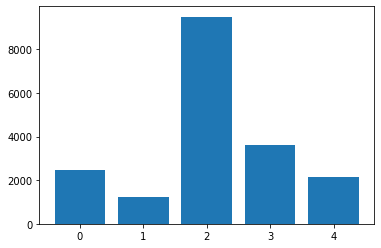

[ 612  306 2376  909  538]
[12.90866906  6.45433453 50.11600928 19.17317022 11.34781692]
100.0


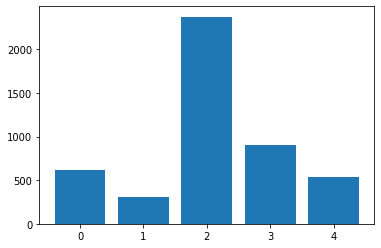

In [14]:
# train
train_ages = np.array([0] * 5)
for i in train_dataset:
    train_ages[i[1]] += 1
print(train_ages)
print(train_ages / len(train_dataset) * 100)
print(sum(train_ages / len(train_dataset) * 100))
plt.bar(range(5), train_ages)
plt.show()
# test
test_ages = np.array([0] * 5)
for i in test_dataset:
    test_ages[i[1]] += 1
print(test_ages)
print(test_ages / len(test_dataset) * 100)
print(sum(test_ages / len(test_dataset) * 100))
plt.bar(range(5), test_ages)
plt.show()

# Model and Loss function

### model

In [15]:
class Model(nn.Module):
    def __init__(self, trial, age_features, ethnicity_features, gender_features):
        super(Model, self).__init__()
        self.name = "Model"

        num_fc_layers = trial.suggest_int("num_fc_layers", 4, 8)
        last_fc = trial.suggest_int("last_fc", 8, 64)

        # fc layer
        self.fc_layers = [nn.Flatten()]

        input_feat = img_size * img_size
        for i in range(num_fc_layers):
            output_feat = trial.suggest_int(f"fc_output_feat_{i}", 8, 64)
            p = trial.suggest_float(f"fc_dropout_{i}", 0, 0.5)

            self.fc_layers.append(nn.Linear(input_feat, output_feat))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(p))
            input_feat = output_feat

        self.fc_layers.append(nn.Linear(input_feat, last_fc))

        self.fc_model = nn.Sequential(*self.fc_layers)

        # classifier
        self.age_classifier = nn.Linear(last_fc, age_features)
        self.eth_classifier = nn.Linear(last_fc, ethnicity_features)
        self.gen_classifier = nn.Linear(last_fc, gender_features)

    def forward(self, x):
        output = self.fc_model(x)
        age = self.age_classifier(output)
        eth = self.eth_classifier(output)
        gen = self.gen_classifier(output)
        return age, eth, gen

### loss function

In [16]:
def loss_function(output, target, reduction="mean"):
    age_loss = nn.CrossEntropyLoss(reduction=reduction).to(device)(output[0], target[0])
    eth_loss = nn.CrossEntropyLoss(reduction=reduction).to(device)(output[1], target[1])
    gen_loss = nn.CrossEntropyLoss(reduction=reduction).to(device)(output[2], target[2])

    return age_loss + eth_loss + gen_loss

# Train

In [17]:
def train(model, train_dataloader, optim, epoch, weight_path=None, quiet=False):
    model.train()
    total_loss_item = 0
    total_acc = 0
    total_age_acc = 0
    if quiet:
        pbar = train_dataloader
    else:
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch:3d}", ascii=True, leave=True)
    for batch_idx, (imgs, ages, eths, gens) in enumerate(pbar):
        imgs = imgs.to(device)
        ages = ages.to(device)
        eths = eths.to(device)
        gens = gens.to(device)
        pred = model(imgs)

        loss = loss_function(pred, (ages, eths, gens))
        total_loss_item += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()

        real = torch.stack((ages, eths, gens), dim=1)  # [B, 3]
        pred_age = torch.argmax(pred[0], dim=1, keepdim=False)  # [B]
        pred_eth = torch.argmax(pred[1], dim=1, keepdim=False)  # [B]
        pred_gen = torch.argmax(pred[2], dim=1, keepdim=False)  # [B]
        pred = torch.stack((pred_age, pred_eth, pred_gen), dim=1)  # [B, 3]
        total_acc += len(torch.where((real == pred).all(dim=1))[0])
        total_age_acc += len(torch.where(ages == pred_age)[0])

    total_loss_item /= len(train_dataloader.dataset)
    accuracy = 100.0 * total_acc / len(train_dataloader.dataset)
    age_accuracy = 100.0 * total_age_acc / len(train_dataloader.dataset)
    if not quiet:
        print(f" + Train Epoch {epoch:3d} ---------------------------")
        print(f" | Loss          : {total_loss_item:8.4f}")
        print(f" | Total accuracy: {total_acc:8}/{len(train_dataloader.dataset)} ({accuracy:8.4f}%)")
        print(f" | Age accuracy  : {total_age_acc:8}/{len(train_dataloader.dataset)} ({age_accuracy:8.4f}%)")
        print(f" +--------------------------------------------")
    if weight_path:
        save_weight(model, weight_path, f"{epoch}.pickle")

# Test

In [18]:
def test(model, test_dataloader, quiet=False):
    model.eval()
    total_loss_item = 0
    total_acc = 0
    total_age_acc = 0
    if quiet:
        pbar = test_dataloader
    else:
        pbar = tqdm(test_dataloader, desc=f"Test", ascii=True, leave=True)
    for imgs, ages, eths, gens in pbar:
        imgs = imgs.to(device)
        ages = ages.to(device)
        eths = eths.to(device)
        gens = gens.to(device)
        pred = model(imgs)

        total_loss_item += loss_function(pred, (ages, eths, gens), reduction="sum").item()

        real = torch.stack((ages, eths, gens), dim=1)  # [B, 3]
        pred_age = torch.argmax(pred[0], dim=1, keepdim=False)  # [B]
        pred_eth = torch.argmax(pred[1], dim=1, keepdim=False)  # [B]
        pred_gen = torch.argmax(pred[2], dim=1, keepdim=False)  # [B]
        pred = torch.stack((pred_age, pred_eth, pred_gen), dim=1)  # [B, 3]
        total_acc += len(torch.where((real == pred).all(dim=1))[0])
        total_age_acc += len(torch.where(ages == pred_age)[0])

    total_loss_item /= len(test_dataloader.dataset)
    accuracy = 100.0 * total_acc / len(test_dataloader.dataset)
    age_accuracy = 100.0 * total_age_acc / len(test_dataloader.dataset)
    if not quiet:
        print(f"[Test] ---------------------------------------")
        print(f" | Loss          : {total_loss_item:8.4f}")
        print(f" | Total accuracy: {total_acc:8}/{len(test_dataloader.dataset)} ({accuracy:8.4f}%)")
        print(f" | Age accuracy  : {total_age_acc:8}/{len(test_dataloader.dataset)} ({age_accuracy:8.4f}%)")
        print(f" +---------------------------------------------")
    return age_accuracy

# Objective

In [19]:
age_features = len(df_data["age"].unique())
eth_features = len(df_data["ethnicity"].unique())
gen_features = len(df_data["gender"].unique())

n_epochs = 50
period = n_epochs // 1


def objective(trial):
    model = Model(trial, age_features, eth_features, gen_features).to(device)
    opt_name = trial.suggest_categorical(
        "optimizer",
        ["Adam", "Adadelta", "RMSprop", "SGD", "MADGRAD"],
    )
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    if opt_name == "MADGRAD":
        optimizer = madgrad.MADGRAD(model.parameters(), lr=lr)
    else:
        optimizer = getattr(optim, opt_name)(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        train(model, train_dataloader, optimizer, epoch, weight_path=None, quiet=(epoch % period))
        accuracy = test(model, test_dataloader, quiet=True)
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# Run

In [20]:
storage = "sqlite:///test.db"
study_name = "002"

# try:
#     study = optuna.load_study(study_name=study_name, storage=storage, sampler=sampler)
# except:
#     study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage, sampler=sampler)

study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage, sampler=RandomSampler(), load_if_exists=True)

study.optimize(objective, n_trials=100)

[I 2022-07-18 04:44:55,992] A new study created in RDB with name: 002


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:45:45,876] Trial 0 finished with value: 63.99493777684033 and parameters: {'num_fc_layers': 4, 'last_fc': 14, 'fc_output_feat_0': 28, 'fc_dropout_0': 0.41348038920746405, 'fc_output_feat_1': 32, 'fc_dropout_1': 0.4666910993972509, 'fc_output_feat_2': 22, 'fc_dropout_2': 0.37305282920673993, 'fc_output_feat_3': 58, 'fc_dropout_3': 0.3345758256595376, 'optimizer': 'Adam', 'lr': 0.0031353865705113586}. Best is trial 0 with value: 63.99493777684033.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0199
 | Total accuracy:     5025/18964 ( 26.4976%)
 | Age accuracy  :    11836/18964 ( 62.4130%)
 +--------------------------------------------


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:46:33,086] Trial 1 finished with value: 50.11600928074246 and parameters: {'num_fc_layers': 4, 'last_fc': 47, 'fc_output_feat_0': 34, 'fc_dropout_0': 0.14269216593038048, 'fc_output_feat_1': 32, 'fc_dropout_1': 0.3209645950925355, 'fc_output_feat_2': 12, 'fc_dropout_2': 0.14751986842648251, 'fc_output_feat_3': 16, 'fc_dropout_3': 0.05427651454698529, 'optimizer': 'Adadelta', 'lr': 0.004490980477844698}. Best is trial 0 with value: 63.99493777684033.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0271
 | Total accuracy:     1742/18964 (  9.1858%)
 | Age accuracy  :     9504/18964 ( 50.1160%)
 +--------------------------------------------


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:47:22,152] Trial 2 finished with value: 65.49251212824299 and parameters: {'num_fc_layers': 5, 'last_fc': 18, 'fc_output_feat_0': 26, 'fc_dropout_0': 0.06635420453415058, 'fc_output_feat_1': 52, 'fc_dropout_1': 0.3201099217351746, 'fc_output_feat_2': 30, 'fc_dropout_2': 0.3751574346577479, 'fc_output_feat_3': 49, 'fc_dropout_3': 0.40050453006713493, 'fc_output_feat_4': 33, 'fc_dropout_4': 0.18454092810313716, 'optimizer': 'MADGRAD', 'lr': 0.00010432288336605341}. Best is trial 2 with value: 65.49251212824299.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0179
 | Total accuracy:     6128/18964 ( 32.3139%)
 | Age accuracy  :    12373/18964 ( 65.2447%)
 +--------------------------------------------


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:48:21,020] Trial 3 finished with value: 50.11600928074246 and parameters: {'num_fc_layers': 7, 'last_fc': 53, 'fc_output_feat_0': 60, 'fc_dropout_0': 0.4372999107174088, 'fc_output_feat_1': 12, 'fc_dropout_1': 0.15759015824836392, 'fc_output_feat_2': 46, 'fc_dropout_2': 0.08258637296894061, 'fc_output_feat_3': 53, 'fc_dropout_3': 0.13850906530736457, 'fc_output_feat_4': 23, 'fc_dropout_4': 0.13653242348475936, 'fc_output_feat_5': 44, 'fc_dropout_5': 0.27356634253795725, 'fc_output_feat_6': 15, 'fc_dropout_6': 0.39325314417408114, 'optimizer': 'Adadelta', 'lr': 0.001030128636326257}. Best is trial 2 with value: 65.49251212824299.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0281
 | Total accuracy:     1537/18964 (  8.1048%)
 | Age accuracy  :     9504/18964 ( 50.1160%)
 +--------------------------------------------


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:49:10,504] Trial 4 finished with value: 59.62877030162413 and parameters: {'num_fc_layers': 7, 'last_fc': 29, 'fc_output_feat_0': 30, 'fc_dropout_0': 0.48082064982365796, 'fc_output_feat_1': 31, 'fc_dropout_1': 0.4766862632224132, 'fc_output_feat_2': 58, 'fc_dropout_2': 0.4855605179130119, 'fc_output_feat_3': 29, 'fc_dropout_3': 0.09188448001911415, 'fc_output_feat_4': 34, 'fc_dropout_4': 0.24748915205182365, 'fc_output_feat_5': 35, 'fc_dropout_5': 0.08329543662133987, 'fc_output_feat_6': 20, 'fc_dropout_6': 0.49683893568288984, 'optimizer': 'RMSprop', 'lr': 0.0011122786375725477}. Best is trial 2 with value: 65.49251212824299.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0221
 | Total accuracy:     4029/18964 ( 21.2455%)
 | Age accuracy  :    11047/18964 ( 58.2525%)
 +--------------------------------------------


[I 2022-07-18 04:49:14,490] Trial 5 pruned. 


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:50:06,254] Trial 6 finished with value: 67.60177177810588 and parameters: {'num_fc_layers': 6, 'last_fc': 24, 'fc_output_feat_0': 36, 'fc_dropout_0': 0.016225409134656366, 'fc_output_feat_1': 61, 'fc_dropout_1': 0.4284657526506286, 'fc_output_feat_2': 49, 'fc_dropout_2': 0.13551661039530455, 'fc_output_feat_3': 46, 'fc_dropout_3': 0.1982516747418307, 'fc_output_feat_4': 57, 'fc_dropout_4': 0.04493982076202707, 'fc_output_feat_5': 13, 'fc_dropout_5': 0.062072207295049364, 'optimizer': 'MADGRAD', 'lr': 0.0001700730078227611}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0162
 | Total accuracy:     7270/18964 ( 38.3358%)
 | Age accuracy  :    12687/18964 ( 66.9004%)
 +--------------------------------------------


[I 2022-07-18 04:50:17,379] Trial 7 pruned. 
[I 2022-07-18 04:50:18,236] Trial 8 pruned. 


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:51:10,130] Trial 9 finished with value: 64.18477114532799 and parameters: {'num_fc_layers': 6, 'last_fc': 60, 'fc_output_feat_0': 50, 'fc_dropout_0': 0.41933372394235424, 'fc_output_feat_1': 34, 'fc_dropout_1': 0.2593103643165573, 'fc_output_feat_2': 25, 'fc_dropout_2': 0.24531996598903316, 'fc_output_feat_3': 28, 'fc_dropout_3': 0.1846470763871394, 'fc_output_feat_4': 49, 'fc_dropout_4': 0.020378629016639727, 'fc_output_feat_5': 43, 'fc_dropout_5': 0.4756478063034742, 'optimizer': 'MADGRAD', 'lr': 0.0017822774986955292}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0200
 | Total accuracy:     5039/18964 ( 26.5714%)
 | Age accuracy  :    11781/18964 ( 62.1230%)
 +--------------------------------------------


[I 2022-07-18 04:51:17,768] Trial 10 pruned. 
[I 2022-07-18 04:51:23,736] Trial 11 pruned. 
[I 2022-07-18 04:51:32,207] Trial 12 pruned. 
[I 2022-07-18 04:51:38,139] Trial 13 pruned. 
[I 2022-07-18 04:51:43,139] Trial 14 pruned. 
[I 2022-07-18 04:51:53,313] Trial 15 pruned. 
[I 2022-07-18 04:52:01,566] Trial 16 pruned. 
[I 2022-07-18 04:52:02,949] Trial 17 pruned. 


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:52:54,495] Trial 18 finished with value: 63.84728960134993 and parameters: {'num_fc_layers': 6, 'last_fc': 21, 'fc_output_feat_0': 58, 'fc_dropout_0': 0.061562726830939496, 'fc_output_feat_1': 64, 'fc_dropout_1': 0.058179290659069516, 'fc_output_feat_2': 26, 'fc_dropout_2': 0.1820018173236541, 'fc_output_feat_3': 48, 'fc_dropout_3': 0.05698226508176807, 'fc_output_feat_4': 63, 'fc_dropout_4': 0.2815605964045429, 'fc_output_feat_5': 50, 'fc_dropout_5': 0.4513279721840426, 'optimizer': 'MADGRAD', 'lr': 0.006141860177852785}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0192
 | Total accuracy:     5650/18964 ( 29.7933%)
 | Age accuracy  :    11955/18964 ( 63.0405%)
 +--------------------------------------------


[I 2022-07-18 04:52:56,765] Trial 19 pruned. 
[I 2022-07-18 04:52:59,501] Trial 20 pruned. 
[I 2022-07-18 04:53:02,036] Trial 21 pruned. 


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:53:53,314] Trial 22 finished with value: 65.80890107572242 and parameters: {'num_fc_layers': 5, 'last_fc': 61, 'fc_output_feat_0': 60, 'fc_dropout_0': 0.054942292057271136, 'fc_output_feat_1': 51, 'fc_dropout_1': 0.28829985948424675, 'fc_output_feat_2': 18, 'fc_dropout_2': 0.27601287189822254, 'fc_output_feat_3': 63, 'fc_dropout_3': 0.4745131849303786, 'fc_output_feat_4': 56, 'fc_dropout_4': 0.47597235394657983, 'optimizer': 'Adam', 'lr': 0.001375659544605936}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0169
 | Total accuracy:     6867/18964 ( 36.2107%)
 | Age accuracy  :    12424/18964 ( 65.5136%)
 +--------------------------------------------


[I 2022-07-18 04:54:00,217] Trial 23 pruned. 
[I 2022-07-18 04:54:02,401] Trial 24 pruned. 
[I 2022-07-18 04:54:04,857] Trial 25 pruned. 
[I 2022-07-18 04:54:13,833] Trial 26 pruned. 
[I 2022-07-18 04:54:16,267] Trial 27 pruned. 
[I 2022-07-18 04:54:18,917] Trial 28 pruned. 
[I 2022-07-18 04:54:19,899] Trial 29 pruned. 
[I 2022-07-18 04:54:22,175] Trial 30 pruned. 
[I 2022-07-18 04:54:24,828] Trial 31 pruned. 


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:55:19,984] Trial 32 finished with value: 64.85973423328412 and parameters: {'num_fc_layers': 6, 'last_fc': 51, 'fc_output_feat_0': 43, 'fc_dropout_0': 0.12093356630642915, 'fc_output_feat_1': 19, 'fc_dropout_1': 0.30989800898083536, 'fc_output_feat_2': 52, 'fc_dropout_2': 0.01391329762154414, 'fc_output_feat_3': 52, 'fc_dropout_3': 0.4937924597497407, 'fc_output_feat_4': 43, 'fc_dropout_4': 0.0028479471314492577, 'fc_output_feat_5': 50, 'fc_dropout_5': 0.05139976010769548, 'optimizer': 'Adam', 'lr': 0.0030888795154403823}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0167
 | Total accuracy:     7152/18964 ( 37.7136%)
 | Age accuracy  :    12478/18964 ( 65.7984%)
 +--------------------------------------------


[I 2022-07-18 04:55:21,201] Trial 33 pruned. 
[I 2022-07-18 04:55:22,549] Trial 34 pruned. 
[I 2022-07-18 04:55:23,742] Trial 35 pruned. 
[I 2022-07-18 04:55:24,948] Trial 36 pruned. 
[I 2022-07-18 04:55:28,410] Trial 37 pruned. 
[I 2022-07-18 04:55:29,372] Trial 38 pruned. 
[I 2022-07-18 04:55:30,259] Trial 39 pruned. 
[I 2022-07-18 04:55:31,373] Trial 40 pruned. 
[I 2022-07-18 04:55:32,226] Trial 41 pruned. 
[I 2022-07-18 04:55:33,356] Trial 42 pruned. 


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:56:28,794] Trial 43 finished with value: 65.66125290023201 and parameters: {'num_fc_layers': 6, 'last_fc': 42, 'fc_output_feat_0': 38, 'fc_dropout_0': 0.2099973840263652, 'fc_output_feat_1': 28, 'fc_dropout_1': 0.09100397070220118, 'fc_output_feat_2': 52, 'fc_dropout_2': 0.00799259413126352, 'fc_output_feat_3': 52, 'fc_dropout_3': 0.3610993688974597, 'fc_output_feat_4': 62, 'fc_dropout_4': 0.027594749290450582, 'fc_output_feat_5': 61, 'fc_dropout_5': 0.4415344561023715, 'optimizer': 'Adam', 'lr': 0.006115169330684321}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0189
 | Total accuracy:     5778/18964 ( 30.4683%)
 | Age accuracy  :    12089/18964 ( 63.7471%)
 +--------------------------------------------


[I 2022-07-18 04:56:29,820] Trial 44 pruned. 
[I 2022-07-18 04:56:31,277] Trial 45 pruned. 
[I 2022-07-18 04:56:32,355] Trial 46 pruned. 
[I 2022-07-18 04:56:35,508] Trial 47 pruned. 
[I 2022-07-18 04:56:36,974] Trial 48 pruned. 
[I 2022-07-18 04:56:38,374] Trial 49 pruned. 
[I 2022-07-18 04:56:39,473] Trial 50 pruned. 
[I 2022-07-18 04:56:40,770] Trial 51 pruned. 


Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:57:32,160] Trial 52 finished with value: 66.7369753216621 and parameters: {'num_fc_layers': 5, 'last_fc': 42, 'fc_output_feat_0': 47, 'fc_dropout_0': 0.48877040650852216, 'fc_output_feat_1': 50, 'fc_dropout_1': 0.19391011615257298, 'fc_output_feat_2': 38, 'fc_dropout_2': 0.07818979759780159, 'fc_output_feat_3': 61, 'fc_dropout_3': 0.2497805589487992, 'fc_output_feat_4': 62, 'fc_dropout_4': 0.1685845126226478, 'optimizer': 'Adam', 'lr': 0.0029136916898769034}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0175
 | Total accuracy:     6715/18964 ( 35.4092%)
 | Age accuracy  :    12305/18964 ( 64.8861%)
 +--------------------------------------------


[I 2022-07-18 04:57:33,590] Trial 53 pruned. 
[I 2022-07-18 04:57:34,786] Trial 54 pruned. 
[I 2022-07-18 04:57:35,813] Trial 55 pruned. 
[I 2022-07-18 04:57:37,952] Trial 56 pruned. 
[I 2022-07-18 04:57:38,812] Trial 57 pruned. 
[I 2022-07-18 04:57:39,747] Trial 58 pruned. 
[I 2022-07-18 04:57:41,128] Trial 59 pruned. 
[I 2022-07-18 04:57:42,376] Trial 60 pruned. 
[I 2022-07-18 04:57:43,828] Trial 61 pruned. 
[I 2022-07-18 04:57:45,208] Trial 62 pruned. 
[I 2022-07-18 04:57:46,433] Trial 63 pruned. 
[I 2022-07-18 04:57:47,386] Trial 64 pruned. 
[I 2022-07-18 04:57:48,883] Trial 65 pruned. 
[I 2022-07-18 04:57:50,266] Trial 66 pruned. 
[I 2022-07-18 04:57:51,706] Trial 67 pruned. 
[I 2022-07-18 04:58:13,539] Trial 68 pruned. 
[I 2022-07-18 04:58:14,477] Trial 69 pruned. 
[I 2022-07-18 04:58:15,685] Trial 70 pruned. 
[I 2022-07-18 04:58:16,668] Trial 71 pruned. 
[I 2022-07-18 04:58:18,201] Trial 72 pruned. 
[I 2022-07-18 04:58:19,118] Trial 73 pruned. 
[I 2022-07-18 04:58:20,402] Trial 

Epoch  50:   0%|          | 0/149 [00:00<?, ?it/s]

[I 2022-07-18 04:59:22,793] Trial 89 finished with value: 67.15882725163468 and parameters: {'num_fc_layers': 4, 'last_fc': 63, 'fc_output_feat_0': 58, 'fc_dropout_0': 0.45800656525164224, 'fc_output_feat_1': 47, 'fc_dropout_1': 0.0717175965536413, 'fc_output_feat_2': 57, 'fc_dropout_2': 0.048758899675706846, 'fc_output_feat_3': 47, 'fc_dropout_3': 0.17608729630504022, 'optimizer': 'RMSprop', 'lr': 0.00309975499765241}. Best is trial 6 with value: 67.60177177810588.


 + Train Epoch  50 ---------------------------
 | Loss          :   0.0160
 | Total accuracy:     7619/18964 ( 40.1761%)
 | Age accuracy  :    12859/18964 ( 67.8074%)
 +--------------------------------------------


[I 2022-07-18 04:59:23,854] Trial 90 pruned. 
[I 2022-07-18 04:59:25,466] Trial 91 pruned. 
[I 2022-07-18 04:59:26,860] Trial 92 pruned. 
[I 2022-07-18 04:59:35,860] Trial 93 pruned. 
[I 2022-07-18 04:59:36,778] Trial 94 pruned. 
[I 2022-07-18 04:59:38,334] Trial 95 pruned. 
[I 2022-07-18 04:59:39,496] Trial 96 pruned. 
[I 2022-07-18 04:59:40,958] Trial 97 pruned. 
[I 2022-07-18 04:59:42,267] Trial 98 pruned. 
[I 2022-07-18 04:59:43,133] Trial 99 pruned. 


In [21]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("num_trials_conducted: ", len(study.trials))
print("num_trials_pruned: ", len(pruned_trials))
print("num_trials_completed: ", len(complete_trials))

trial = study.best_trial
print("[+] results: -----------------------------------------")
print(" | results from best trial:")

print(" | accuracy: ", trial.value)
print(" | hyperparameters: ")
for key, value in trial.params.items():
    print(f" | {key}: {value}")
print(" +----------------------------------------------------")
    

num_trials_conducted:  100
num_trials_pruned:  87
num_trials_completed:  13
[+] results: -----------------------------------------
 | results from best trial:
 | accuracy:  67.60177177810588
 | hyperparameters: 
 | fc_dropout_0: 0.016225409134656366
 | fc_dropout_1: 0.4284657526506286
 | fc_dropout_2: 0.13551661039530455
 | fc_dropout_3: 0.1982516747418307
 | fc_dropout_4: 0.04493982076202707
 | fc_dropout_5: 0.062072207295049364
 | fc_output_feat_0: 36
 | fc_output_feat_1: 61
 | fc_output_feat_2: 49
 | fc_output_feat_3: 46
 | fc_output_feat_4: 57
 | fc_output_feat_5: 13
 | last_fc: 24
 | lr: 0.0001700730078227611
 | num_fc_layers: 6
 | optimizer: MADGRAD
 +----------------------------------------------------


In [22]:
optuna.visualization.plot_optimization_history(study)


In [23]:
optuna.visualization.plot_parallel_coordinate(study)


In [25]:
# 하이퍼파라미터 중요도
optuna.importance.get_param_importances(study)
optuna.visualization.plot_param_importances(study)

In [27]:
optuna.visualization.plot_contour(study, params=["optimizer", "lr"])